In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import random

#nilearn imports
from nilearn import plotting, image, interfaces
from nilearn.image import mean_img
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, show, plot_design_matrix
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.reporting import get_clusters_table
import nilearn
import nibabel as nib
from nilearn.maskers import NiftiMasker

#sklearn imports
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [2]:
#load data
def load_beta_data():
    
    X, y = [], []
    
    directories = [Path("~/teams/a05/group_1_data/confoundBeta/").expanduser(), 
    Path("~/teams/a05/group_1_data/confoundBeta/betas/").expanduser()]

    for directory in directories:
        
        beta_files = list(directory.glob("beta_*.nii.gz"))

        for file_path in beta_files:
            
            file_name = file_path.stem
            subjID = file_name.split("_")[1]
            task = file_name.split("_")[2]

            beta_img = nib.load(str(file_path))
            beta_data = beta_img.get_fdata().flatten()
            
            X.append(beta_data)
            y.append(task)

    return np.array(X), np.array(y)

X, y = load_beta_data()

In [3]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
def split_train_test_valid(X, y): #split data into 20% test 20% validation 60% training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) #0.25 * 0.8 = 0.2
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_valid(X, y)

In [6]:
def NB_model(X_train, y_train, X_test, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return model

Model Accuracy: 0.3889


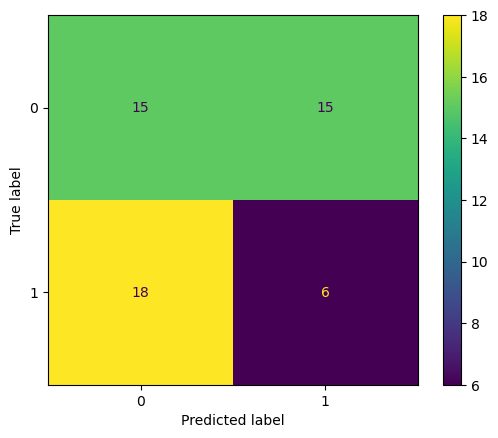

GaussianNB()

In [7]:
NB_model(X_train, y_train, X_val, y_val) # No PCA

In [8]:
#hyperparam tuning
model = GaussianNB()

params = {'var_smoothing': np.logspace(0,-9, num=100)}
search = GridSearchCV(estimator=model, 
                 param_grid=params, 
                 #cv='cv_method',   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
search.fit(X_train, y_train)

search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 0.0023101297000831605}

Model Accuracy: 0.7593


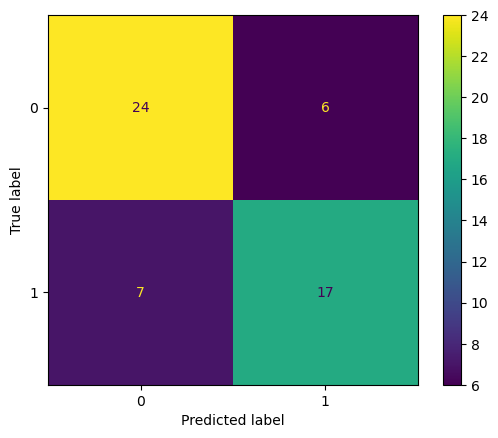

In [9]:
model = GaussianNB(var_smoothing=search.best_params_['var_smoothing'])
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


Model Accuracy: 0.8545


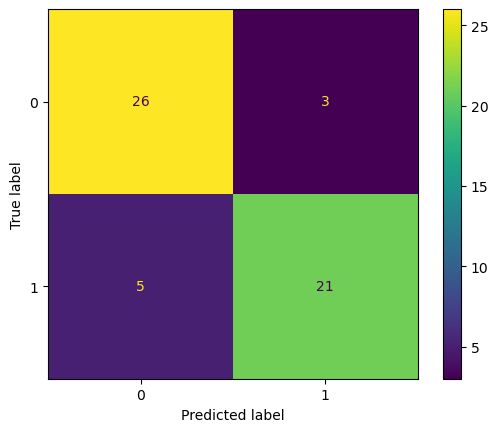

In [10]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Model Accuracy: 0.8148


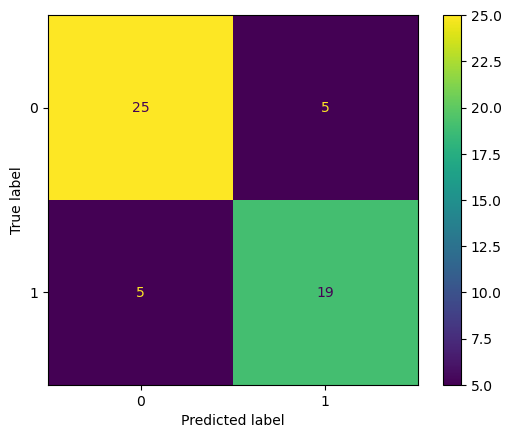

GaussianNB()

In [11]:
#PCA
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_valid(X, y)
pca = PCA(n_components = 30) #from a cluster table from last quarter, more testing should be done to find optimal n 
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
NB_model(X_train, y_train, X_val, y_val)

Model Accuracy: 0.8148


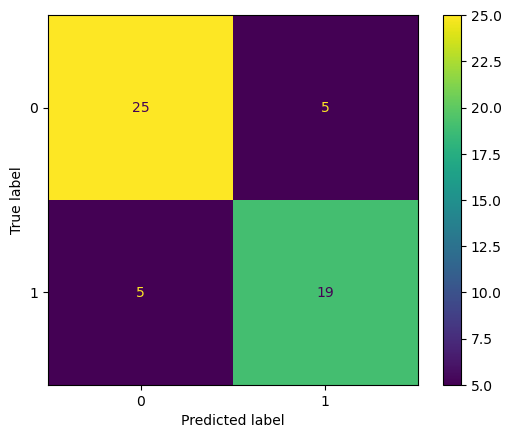

In [12]:
#PCA + best_param
model = GaussianNB(var_smoothing=search.best_params_['var_smoothing'])
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [13]:
subjects = [103, 105, 106, 109, 110, 115, 117, 124, 
           127, 130, 131, 133, 138, 140, 142, 143, 145,
           147, 157, 159, 161, 165, 172, 176, 177, 178,
           180, 181, 182, 183, 188, 200, 207, 208]
data_type = 'confound'

In [14]:
def load_beta_data_custom_split(subjects, data_type):
    X_train, y_train = [], []
    X_test, y_test = [], []

    mask_img = nilearn.datasets.load_mni152_brain_mask(resolution=2, threshold=0.2)
    masker = NiftiMasker(mask_img=mask_img, memory="nilearn_cache", memory_level=1).fit()

    taskType = ['colorwheel', 'samedifferent']

    for subjID in subjects:
        subject_runs = {}
        for task in taskType:
            runs = []
            for run in range(1, 5): 
                file_path = Path(f"~/teams/a05/group_1_data/{data_type}Beta/beta_{subjID}_{task}_{run}.nii.gz").expanduser()
                if file_path.exists():
                    runs.append((run, file_path))
            
            if len(runs) == 4:
                train_runs = runs[:3]
                test_run = runs[3]

                for run, file_path in train_runs:
                    beta_img = nib.load(str(file_path))
                    # Transform the data using the masker
                    beta_data = masker.transform(beta_img).flatten()
                    X_train.append(beta_data)
                    y_train.append(task)

                run, file_path = test_run
                beta_img = nib.load(str(file_path))
                
                beta_data = masker.transform(beta_img).flatten()
                X_test.append(beta_data)
                y_test.append(task)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), masker

In [15]:
X_train, y_train, X_test, y_test, masker = load_beta_data_custom_split(subjects, data_type)
print(f"Train Samples: {len(X_train)}, Test Samples: {len(X_test)}")

Train Samples: 201, Test Samples: 67


In [16]:
def NB_model(X_train, y_train, X_test, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return model

Model Accuracy: 0.6269


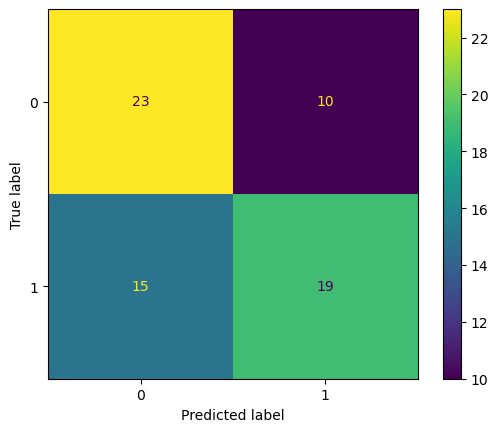

GaussianNB()

In [17]:
NB_model(X_train, y_train, X_test, y_test)